# **CS357000 Introduction to Multimedia - HW3**

In this homework, you'll be engaging with fundamental concepts of motion estimation, including 
+   Implementation and visualization
+   Temporal Performance Analysis of Motion Estimation
+   Computational Efficiency analysis

Each question is designed to build your understanding and skills in these areas.   
Follow the instructions carefully and complete the tasks in the provided code blocks.  
Additionally, you will be required to write a report in the designated sections to explain your methodology and findings.  

# **Submission**
+   Ensure that you have completed all tasks and filled in all reports before submitting.
+   Compress your code and results in a zip file named HW3_{StudentID}.zip and upload to eeclass before the deadline 
+   The structure and naming of the files must be consistent with the specifications outlined in the description file

In [1]:
# Lib
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

In [2]:
def calculate_SAD(ref_block, target_block):
    '''
    In :
        ref_block : reference block
        target_block : target block
    Out : 
        sad : SAD value
    '''
    # TODO calculate the SAD value
    SAD = np.sum(np.abs(ref_block.astype(int) - target_block.astype(int)))
    
    return SAD

In [3]:
def calculate_PSNR(predicted_img, target_img):
    '''
    In :
        predicted_img : predicted image
        target_img : target image
    Out : 
        PSNR : PSNR value
    '''
    # TODO calculate the PSNR value
    MSE = np.mean(np.sum(((predicted_img.astype(int) - target_img.astype(int)) ** 2), axis=-1))
    PSNR = 10 * np.log10((255) ** 2 / MSE)
    
    return PSNR

In [51]:
def full_search(ref_img, target_block, corner_pt, search_range, block_size):
    '''
    In :
        ref_img : reference image
        target_block : target block
        corner_pt : top-left corner coordinate of the target block, (x, y) = (col, row)
        search_range : search range
        block size : size of macroblock
    Out : 
        predicted_block : predicted block
        motion vector : motion vector
        SAD : SAD value
    '''
    # TODO calculate the predicted block, motion vector, and SAD value
    predicted_block = target_block.copy()
    motion_vector = np.zeros(2)
    h, w, c = ref_img.shape
    target_i, target_j = corner_pt[1], corner_pt[0]

    # search boundary
    top = target_i - search_range if target_i - search_range > 0 else 0
    bottom = target_i + search_range if target_i + search_range + block_size <= h else h - block_size
    left = target_j - search_range if target_j - search_range > 0 else 0
    right = target_j + search_range if target_j + search_range + block_size <= w else w - block_size

    # full search
    min_SAD = 1e9
    best_i, best_j = 0, 0
    for i in range(top, bottom):
        for j in range(left, right):
            ref_block = ref_img[i:i+block_size, j:j+block_size, :]
            now_SAD = calculate_SAD(ref_block, target_block)
            if(now_SAD < min_SAD):
                min_SAD = now_SAD
                best_i, best_j = i, j
                predicted_block = ref_block.copy()
                
    
    motion_vector[0] = int(best_j - target_j)
    motion_vector[1] = int(best_i - target_i)
    SAD = min_SAD

    return predicted_block, motion_vector, SAD

In [14]:
def twoD_log_search(ref_img, target_block, corner_pt, search_range, block_size):
    '''
    In :
        ref_img : reference image
        target_block : target block
        corner_pt : top-left corner coordinate of the target block
        search_range : search range
        block size : size of macroblock
    Out : 
        predicted_block : predicted block
        motion vector : motion vector
        SAD : SAD value
    '''
    # TODO calculate the predicted block, motion vector, and SAD value
    predicted_block = target_block.copy()
    motion_vector = np.zeros(2)
    h, w, c = ref_img.shape
    target_i, target_j = corner_pt[1], corner_pt[0]

    # search boundary
    top = target_i - search_range if target_i - search_range > 0 else 0
    bottom = target_i + search_range if target_i + search_range + block_size < h else h - block_size
    left = target_j - search_range if target_j - search_range > 0 else 0
    right = target_j + search_range if target_j + search_range + block_size < w else w - block_size

    half_size = block_size // 2
    center_i, center_j = target_i, target_j
    min_SAD = calculate_SAD(ref_img[center_i:center_i+block_size, center_j:center_j+block_size, :], target_block)
    best_i, best_j = center_i, center_j
    while(1):
        drow = [-half_size, half_size, 0, 0]
        dcol = [0, 0, -half_size, half_size]
        now_min_SAD = 1e9
        now_best_i, now_best_j = 0, 0

        # four-points search (exclude center point, since it was already calculated)
        for i in range(4):
            now_i, now_j = center_i + drow[i], center_j + dcol[i]
            if(now_i < top or now_i >= bottom or now_j < left or now_j >= right):
                continue
            ref_block = ref_img[now_i:now_i+block_size, now_j:now_j+block_size, :]
            now_SAD = calculate_SAD(ref_block, target_block)
            if(now_SAD < now_min_SAD):
                now_min_SAD = now_SAD
                now_best_i, now_best_j = now_i, now_j
        
        # find the minimum direction
        if(now_min_SAD < min_SAD):
            min_SAD = now_min_SAD
            best_i, best_j = now_best_i, now_best_j
            center_i, center_j = best_i, best_j
        # if four points SAD are all greater than center, shrink size
        else:
            half_size //= 2
        
        # final step, find the minimum amoung nine points
        if(half_size <= 1):
            for i in range(center_i - 1, center_i + 2):
                for j in range(center_j - 1, center_j + 2):
                    if(i < top or i >= bottom or j < left or j >= right):
                        continue  
                    ref_block = ref_img[i:i+block_size, j:j+block_size, :]
                    now_SAD = calculate_SAD(ref_block, target_block)
                    if(now_SAD < min_SAD):
                        min_SAD = now_SAD
                        best_i, best_j = i, j
                        predicted_block = ref_block.copy()
            break

    motion_vector[0] = int(best_j - target_j)
    motion_vector[1] = int(best_i - target_i)
    SAD = min_SAD

    return predicted_block, motion_vector, SAD

In [6]:
def get_residual_img(predicted_img, target_img):
    '''
    In :
        predicted_img : predicted image
        target_img : target image
    Out : 
        residual_img : residual image
    '''
    # TODO get residual image
    # residual_img = predicted_img.copy()
    predicted_Y = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2YCrCb)[:, :, 0]
    target_Y = cv2.cvtColor(target_img, cv2.COLOR_RGB2YCrCb)[:, :, 0]
    residual_img = target_Y - predicted_Y
    
    return residual_img

In [7]:
def get_motion_vector_img(target_img, motion_vectors, block_size):
    '''
    In :
        target_img : target image
        motion_vectors : motion vectors
        block_size : size of macroblock
    Out : 
        motion_vector_img : motion vector image
    '''
    # TODO get motion vector image
    motion_vector_img = target_img.copy()
    h, w, c = target_img.shape
    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            motion_vector = motion_vectors[y // block_size, x // block_size]
            dx, dy = motion_vector[0], motion_vector[1]
            predict_x = x + dx
            predict_y = y + dy
            cv2.arrowedLine(motion_vector_img, (predict_x, predict_y), (x, y), (0, 0, 255), 1, tipLength=0.3)
    
    return motion_vector_img

In [8]:
def perform_motion_estimation(method, search_range, block_size, ref_img, target_img):
    '''
    In :
        method : target image
        search_range : motion vectors
        block_size : size of macroblock
        ref_img : reference image
        target_img : target image
    Out : 
        (depend on how you design this function)
    '''
    # TODO perform motion estimation

    assert method in ['full_search', '2d_log_search']
    h, w, c = ref_img.shape
    motion_vectors = np.zeros((int(h / block_size), int(w / block_size), 2), dtype=int)
    predicted_img = np.zeros((h, w, c)).astype(np.uint8)
    total_sad = 0

    for y in range(0, h, block_size):
        for x in range(0, w, block_size):
            if method == 'full_search':
                predicted_block, motion_vector, sad = full_search(ref_img, target_img[y:y+block_size, x:x+block_size, :], (x, y), search_range, block_size)
            elif method == '2d_log_search':
                predicted_block, motion_vector, sad = twoD_log_search(ref_img, target_img[y:y+block_size, x:x+block_size, :], (x, y), search_range, block_size)
            
            motion_vectors[y // block_size, x // block_size] = motion_vector
            total_sad += sad
            predicted_img[y:y+block_size, x:x+block_size, :] = predicted_block
            
    return motion_vectors, predicted_img, total_sad

## **Section 1 - Implementation and Visualization (60%)**
Implement both search algorithms with search ranges of p=8 and p=16 in combination with two macroblock sizes of 8x8 and 16x16, respectively. The reference image is ‘00080.jpg’, and the target image is ‘00084.jpg’.

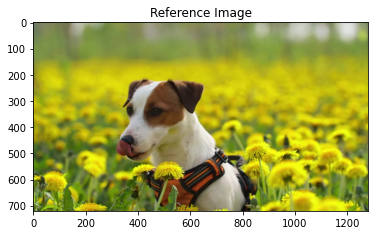

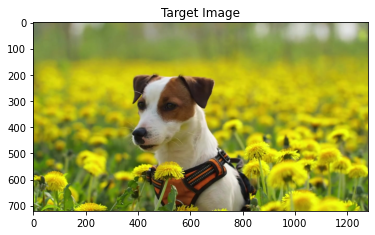

In [49]:
# set image path
ref_img_path = 'src/00080.jpg'
target_img_path = 'src/00084.jpg'

# read image
ref_img = cv2.imread(ref_img_path)
target_img = cv2.imread(target_img_path)

# convert image
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)
target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)

# show image
plt.title("Reference Image")
plt.imshow(ref_img)
plt.show()

plt.title("Target Image")
plt.imshow(target_img)
plt.show()

Total SAD: 15581808
PSNR: 17.97146353079462


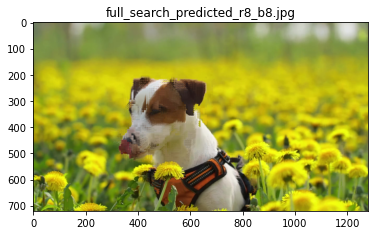

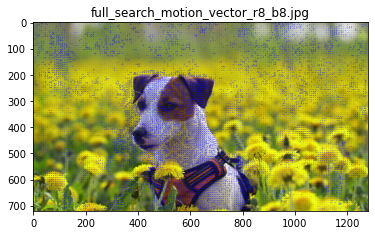

True

In [52]:
# method=full_search, search_range=8, block_size=8
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=8, block_size=8, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "full_search_predicted_r8_b8.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "full_search_motion_vector_r8_b8.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=8)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Residual Image
# file_name = "full_search_residual_r8_b8.jpg"
# residual_img = get_residual_img(predicted_img, target_img)
# plt.title(file_name)
# plt.imshow(residual_img)
# plt.show()

Total SAD: 17706468
PSNR: 17.43626037801124


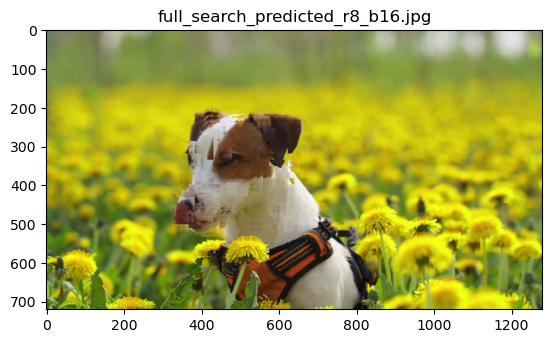

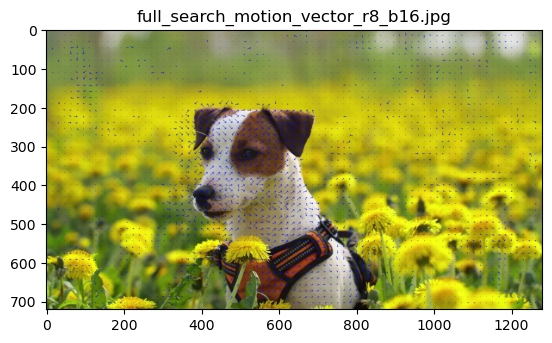

True

In [19]:
# method=full_search, search_range=8, block_size=16
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "full_search_predicted_r8_b16.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "full_search_motion_vector_r8_b16.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=16)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

In [ ]:
# method=full_search, search_range=16, block_size=8
perform_motion_estimation(method='full_search', search_range=16, block_size=8, ref_img=ref_img, target_img=target_img)

In [ ]:
# method=full_search, search_range=16, block_size=16
perform_motion_estimation(method='full_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)

Total SAD: 16382487
PSNR: 18.92302041727173


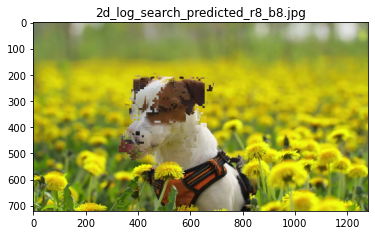

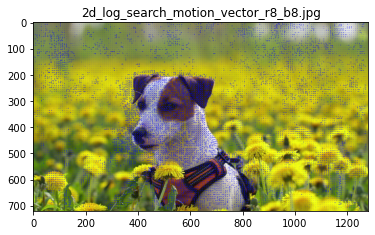

True

In [15]:
# method=2d_log_search, search_range=8, block_size=8
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=8, block_size=8, ref_img=ref_img, target_img=target_img)
print("Total SAD:",total_sad)
print("PSNR:", calculate_PSNR(predicted_img, target_img))

# Predicted Image
file_name = "2d_log_search_predicted_r8_b8.jpg"
plt.title(file_name)
plt.imshow(predicted_img)
plt.show()
output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

# Motion Vector Image
file_name = "2d_log_search_motion_vector_r8_b8.jpg"
motion_vector_img = get_motion_vector_img(target_img, motion_vectors, block_size=8)
plt.title(file_name)
plt.imshow(motion_vector_img)
plt.show()
output_img = cv2.cvtColor(motion_vector_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output/' + file_name, output_img)

In [ ]:
# method=2d_log_search, search_range=8, block_size=16
perform_motion_estimation(method='2d_log_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)

In [ ]:
# method=2d_log_search, search_range=16, block_size=8
perform_motion_estimation(method='2d_log_search', search_range=16, block_size=8, ref_img=ref_img, target_img=target_img)

In [ ]:
# method=2d_log_search, search_range=16, block_size=16
perform_motion_estimation(method='2d_log_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)

## **Section 2 - Temporal Performance Analysis of Motion Estimation (30%)**
Implement the 2D Logarithmic Search method across an entire video sequence using a search range of p=16 and macroblock size of 16x16. The sequence starts with the reference frame ‘00050.jpg’, and subsequent frames in the video serve as target images.

In [30]:
def frames_to_video(image_folder, video_path, frame_width, frame_height, fps=30, img_postfix='.jpg'):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (frame_width, frame_height))
    images = glob.glob(os.path.join(image_folder, '*'+img_postfix))
    images.sort()
    for image_file in images:
        img = cv2.imread(image_file)
        if img is not None:
            img = cv2.resize(img, (frame_width, frame_height))
            video_writer.write(img)
    video_writer.release()
    
    print(f'Video saved as {video_path}')

In [18]:
img_list = os.listdir('src')
print(img_list[1:])

['00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', '00076.jpg', '00077.jpg', '00078.jpg', '00079.jpg', '00080.jpg', '00081.jpg', '00082.jpg', '00083.jpg', '00084.jpg', '00085.jpg', '00086.jpg', '00087.jpg', '00088.jpg', '00089.jpg', '00090.jpg', '00091.jpg', '00092.jpg', '00093.jpg', '00094.jpg', '00095.jpg', '00096.jpg', '00097.jpg', '00098.jpg', '00099.jpg', '00100.jpg', '00101.jpg', '00102.jpg', '00103.jpg', '00104.jpg', '00105.jpg', '00106.jpg', '00107.jpg', '00108.jpg', '00109.jpg', '00110.jpg', '00111.jpg', '00112.jpg', '00113.jpg', '00114.jpg', '00115.jpg', '00116.jpg', '00117.jpg', '00118.jpg', '00119.jpg', '00120.jpg']


In [35]:
# set image path
ref_img_path = 'src/00050.jpg'
ref_img = cv2.imread(ref_img_path)
ref_img = cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB)

# get image list
img_list = os.listdir('src')
img_list = img_list[1:]

total_SAD_list = []
PSNR_list = []

# generate predict and residual image frames
for img_dir in img_list:
    # read and convert image
    target_img_path = 'src/' + img_dir
    target_img = cv2.imread(target_img_path)
    target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
    
    # motion estimation and calculate PSNR
    motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)
    PSNR = calculate_PSNR(predicted_img, target_img)
    total_SAD_list.append(total_sad)
    PSNR_list.append(PSNR)
    
    # write image frame
    output_img = cv2.cvtColor(predicted_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('predicted_frames/' + img_dir, output_img)
    
    print(img_dir, ":")
    print("Total SAD:",total_sad)
    print("PSNR:", PSNR)
    print()
    

00051.jpg :
Total SAD: 3891620
PSNR: 35.249565099383204

00052.jpg :
Total SAD: 5071330
PSNR: 32.62373266607129

00053.jpg :
Total SAD: 6081321
PSNR: 31.50012318433933

00054.jpg :
Total SAD: 6697027
PSNR: 30.062560545987246

00055.jpg :
Total SAD: 7275938
PSNR: 28.479086762425744

00056.jpg :
Total SAD: 7818398
PSNR: 28.038192381306224

00057.jpg :
Total SAD: 8475177
PSNR: 27.386097923386266

00058.jpg :
Total SAD: 9344595
PSNR: 25.972106556364377

00059.jpg :
Total SAD: 10443812
PSNR: 24.593752586654425

00060.jpg :
Total SAD: 11633114
PSNR: 23.312430409189716

00061.jpg :
Total SAD: 12750557
PSNR: 22.566411736747792

00062.jpg :
Total SAD: 14001020
PSNR: 21.847284474397423

00063.jpg :
Total SAD: 15827495
PSNR: 20.30224574076856

00064.jpg :
Total SAD: 17965244
PSNR: 19.24498816213093

00065.jpg :
Total SAD: 19965680
PSNR: 18.365695094403286

00066.jpg :
Total SAD: 22042562
PSNR: 17.697108002292154

00067.jpg :
Total SAD: 24416858
PSNR: 17.19850933496694

00068.jpg :
Total SAD: 2643

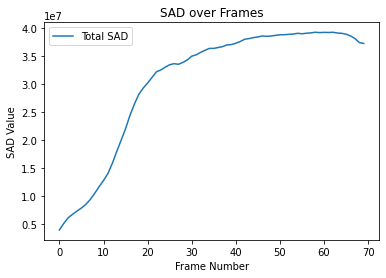

In [36]:
# TODO plot total SAD curve across the video sequence to capture the performance metrics dynamically and describe what you observe
plt.plot(total_SAD_list, label='Total SAD')
plt.title('SAD over Frames')
plt.xlabel('Frame Number')
plt.ylabel('SAD Value')
plt.legend()

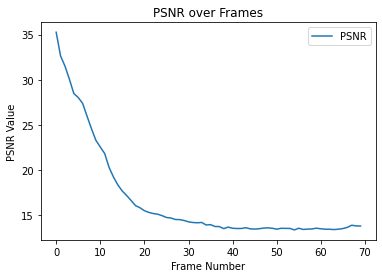

In [37]:
# TODO plot PSNR curve across the video sequence to capture the performance metrics dynamically and describe what you observe
plt.plot(PSNR_list, label='PSNR')
plt.title('PSNR over Frames')
plt.xlabel('Frame Number')
plt.ylabel('PSNR Value')
plt.legend()

In [38]:
# TODO generate predicted images and residual images for each frame in the sequence in relation to the reference frame and compile them into two video files to visualize the temporal consistency of the motion estimation
# frames_to_video('src', 'output/original.mp4', frame_width=1280, frame_height=720, fps=30)
frames_to_video('predicted_frames', 'output/predicted.mp4', frame_width=1280, frame_height=720, fps=30)

Video saved as output/original.mp4
Video saved as output/predicted.mp4


## **Section 3 - Computational Efficiency Analysis (10%)**
 - Measure the execution time required for the two search algorithms with the two different search range sizes p=8 and p=16
 - Compare and discuss the execution time with the theoretical time complexity for the two search algorithms

In [43]:
# TODO
import time

# full search p=8 and block size=16
start_time = time.time()
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)
end_time = time.time()
print("Excution time of full search with p=8 and block size=16:", round((end_time - start_time), 2), 's')

# full search p=16 and block size=16
start_time = time.time()
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='full_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)
end_time = time.time()
print("Excution time of full search with p=16 and block size=16:", round((end_time - start_time), 2), 's')

# 2d log search p=8 and block size=16
start_time = time.time()
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=8, block_size=16, ref_img=ref_img, target_img=target_img)
end_time = time.time()
print("Excution time of 2d log search with p=8 and block size=16:", round((end_time - start_time), 2), 's')

# 2d log search p=16 and block size=16
start_time = time.time()
motion_vectors, predicted_img, total_sad = perform_motion_estimation(method='2d_log_search', search_range=16, block_size=16, ref_img=ref_img, target_img=target_img)
end_time = time.time()
print("Excution time of 2d log search with p=16 and block size=16:", round((end_time - start_time), 2), 's')

Excution time of full search with p=8 and block size=16: 9.03 s
Excution time of full search with p=16 and block size=16: 34.87 s
Excution time of 2d log search with p=8 and block size=16: 0.96 s
Excution time of 2d log search with p=16 and block size=16: 1.15 s
